In [2]:
import numpy as np
from sklearn.datasets import make_blobs, make_regression
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import utils as ut
import pandas as pd
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

In [3]:
tf.random.set_seed(42) # TF
np.random.seed(42) # Numpy
random.seed(10) # Python

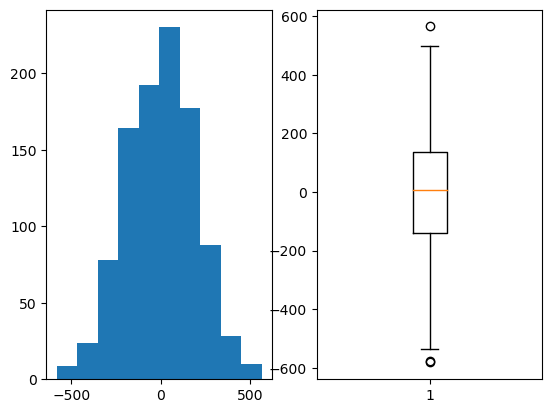

In [4]:
X,y = make_regression(n_samples=1000, n_features=20, noise=0.1)
n_train = 500
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]
plt.subplot(121)
plt.hist(y)

plt.subplot(122)
_ = plt.boxplot(y)


## Simple regression model to demonstrate exploding gradients problem 

2023-08-01 16:19:02.257019: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


nan nan


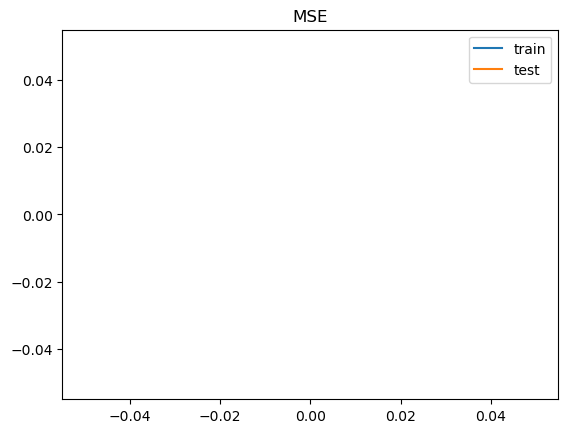

In [5]:
model = tf.keras.Sequential()
model.add(layers.Dense(20, activation='relu', name='layer-0', kernel_initializer='he_uniform'))
model.add(layers.Dense(1, activation='linear', name='layer-1'))

opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='mse')

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)

plt.title('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

print(train_mse, test_mse)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


layer-0/kernel:0, shape: (20, 20)
[<tf.Variable 'layer-0/kernel:0' shape=(20, 20) dtype=float32, numpy=
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
    

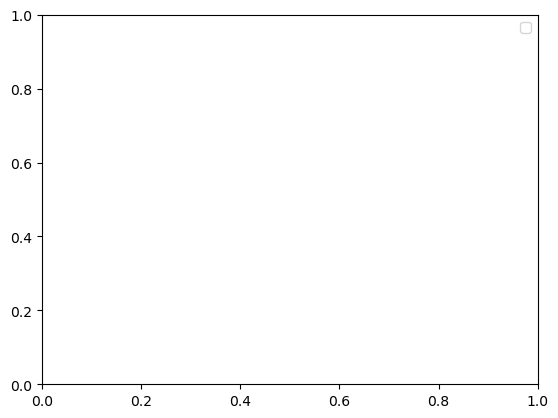

In [6]:
num_layers = [3,10]
#num_layers = [1]
activation = 'sigmoid'
with tf.GradientTape() as tape:
      pred = model(trainX)
      loss = tf.keras.losses.mse(trainy, pred)
      grads = tape.gradient(loss, model.trainable_variables)

  # plot learning curve
plt.figure()
for var, g in zip(model.trainable_variables, grads):
    print(f'{var.name}, shape: {g.shape}')    
    #if 'layer-0/kernel' in var.name:
    print(model.trainable_variables)
    #print(g.numpy().flatten())
    #plt.plot(g.numpy().flatten())
        
plt.legend()
plt.show()

## Scaling of x response only

In [9]:
trainX = trainy.reshape(len(trainX), 1)
testX = testy.reshape(len(testX), 1)

scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)

nan nan


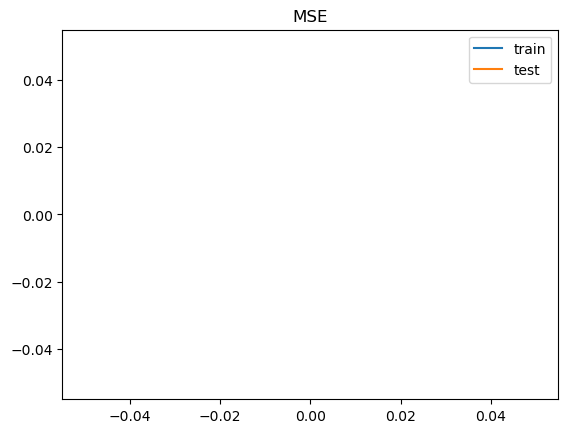

In [10]:
model = tf.keras.Sequential()
model.add(layers.Dense(20, activation='relu', name='layer-0', kernel_initializer='he_uniform'))
model.add(layers.Dense(1, activation='linear', name='layer-1'))

opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='mse')

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=0)
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)

plt.title('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

print(train_mse, test_mse)

### Observations:
- Continue to get nan even when features are scaled showing that weights are impacted by response 

- This problem happens because of weights, not because of the activation function. 
- Due to high weight values, the derivatives will also higher so that the new weight varies a lot to the older weight.
Derivatives are higher because at some point weights are part of gradient calculation. 
- Because of high gradient values we get big changes in weights. 
- As result the gradient will never converge. 
- So it may result in oscillating around minima and never come to a global minima point.